### GAN(Generative Adversarial Network)
1. 생성기(G)와 식별기(D)의 두 가지가 서로 적대적인 학습을 실시하는 것 
2. 생성기는 생성한 데이터가 가능한 실제에 가깝도록 생성하는 것이 목표
3. 식별기는 입력된 데이터가 진짜인지 생성기에서 생성된 데이터인지 정밀하게 식별하는 것이 목표
4. 생성기는 노이즈로부터 실제에 가까운 데이터를 생성하도록 학습 
5. 식별기는 실제 데이터와 생성된 데이터가 구별이 불가능할 때 학습이 수렴 
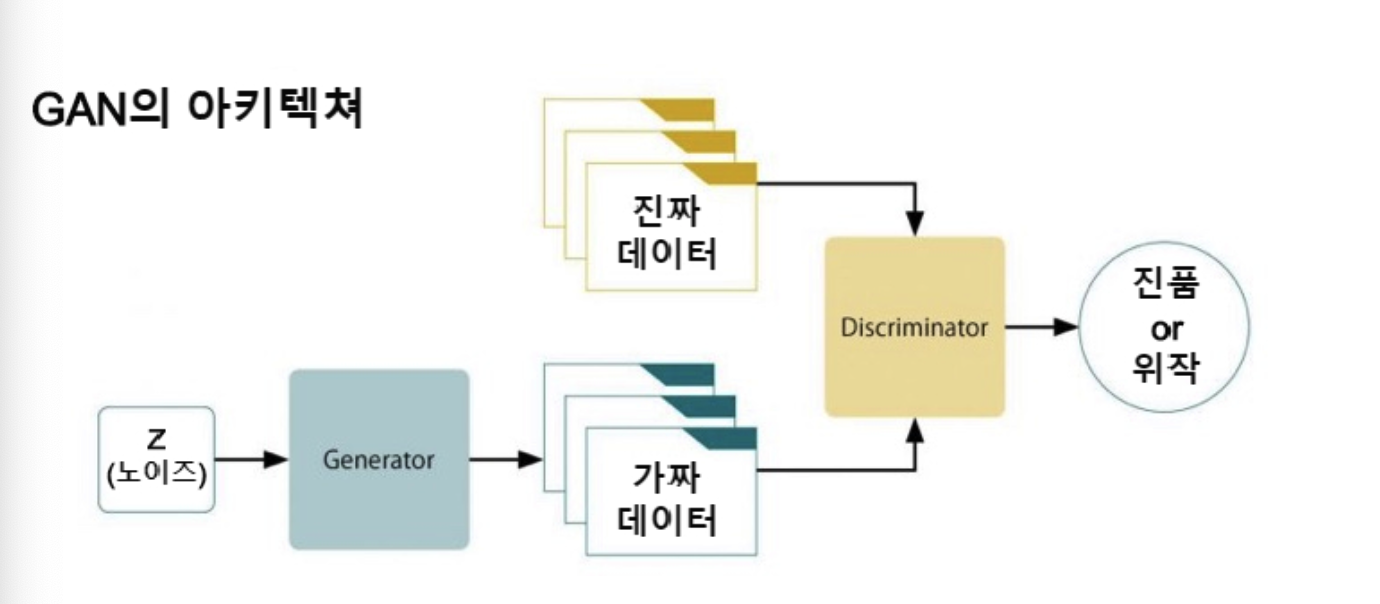


In [1]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

     |████████████████████████████████| 11.3 MB 2.6 MB/s eta 0:00:01
  Created wheel for pillow: filename=Pillow-4.1.1-cp37-cp37m-macosx_10_9_x86_64.whl size=443365 sha256=540cd3a302b1bce0aaadd4d1af4784dbd0b8475c48c69fe42b84ae02c3d17575
  Stored in directory: /Users/Moon/Library/Caches/pip/wheels/51/53/67/d76ff9fd54dd89a25efce20d2e7c9b35348db386b53deb8095
Successfully built pillow
  Attempting uninstall: pillow
    Found existing installation: Pillow 6.2.0
    Uninstalling Pillow-6.2.0:
      Successfully uninstalled Pillow-6.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.15.0 requires pillow>=4.3.0, but you have pillow 4.1.1 which is incompatible.
You should consider upgrading via the '/Users/Moon/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [4]:
# 전치 컨볼루션 연산 <- 잘모르겠음
# 이미지 크기를 2배로 늘리는 방법 
test = torch.ones(1, 1, 16, 16)
conv1 = nn.ConvTranspose2d(1, 1, kernel_size = 4, stride = 2, padding = 1)
out = conv1(test)
print(out.size())

conv1 = nn.ConvTranspose2d(1, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
out = conv1(test)
print(out.size())

torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32])


In [10]:
epoch = 50
batch_size = 512
learning_rate = 0.0002
num_gpus = 1 # ?
z_size = 50 # 입력값의 벡터 사이즈 
middle_size = 200

In [6]:
# Download Data

mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

### Generater(생성기)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(z_size, middle_size)),
            ('bn1', nn.BatchNorm1d(middle_size)),
            ('act1', nn.ReLU()),
        ]))
        
        self.layer2 = nn.Sequential(OrderedDict([
            ('fc2', nn.Linear(middle_size, 784)),
            ('tanh', nn.Tanh()),
        ]))
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = out.view(batch_size, 1, 28, 28)
        return out
    
# OrderdDict : 순서를 기억하지 못하는 일반 딕셔너리와 다르게 순서가 저장되는 딕셔너리 

### Discriminator(구별자)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(784, middle_size)),
            ('act1', nn.LeakyReLU()),
        ]))
        
        self.layer2 = nn.Sequential(OrderedDict([
            ('fc2', nn.Linear(middle_size, 1)),
            ('bn2', nn.BatchNorm1d(1)),
            ('act2', nn.Sigmoid()),
        ]))
        
    def forward(self, x):
        out = x.view(batch_size, -1)
        out = self.layer1(out)
        out = self.layer2(out)
        return out 
    # out으로 나온 결과는 0~1 사이의 값으로 나온다 즉, 실제 데이터인지 가짜 데이터인지 파악하기 위한 지표 

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

gen_params = generator.state_dict().keys()
dis_params = discriminator.state_dict().keys()

for i in gen_params:
    print(i)

# 딕셔너리 형태를 사용해서 각 파라미터를 뽑음 

cpu
layer1.fc1.weight
layer1.fc1.bias
layer1.bn1.weight
layer1.bn1.bias
layer1.bn1.running_mean
layer1.bn1.running_var
layer1.bn1.num_batches_tracked
layer2.fc2.weight
layer2.fc2.bias


In [15]:
loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = (0.5, 0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (0.5, 0.999))

ones_label = torch.ones(batch_size, 1).to(device)
zeros_label = torch.zeros(batch_size, 1).to(device)

In [17]:
# model restore if any

try:
    generator, discriminator = torch.load('./model/vanilla_gan.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass
  
try:
    os.mkdir("./model")
except:
    pass

try:
    os.mkdir("./result")
except:
    pass


--------model not restored--------



### Train 

In [22]:
for i in range(epoch):
    for j,(image, label) in enumerate(train_loader):
        image = image.to(device)
        
        dis_optim.zero_grad()
        
        z = init.normal_(torch.Tensor(batch_size, z_size), mean = 0, std = 0.1).to(device)
        # 랜덤하게 입력값인 z를 샘플링 
        gen_fake = generator.forward(z)
        # z를 통해 가상의 이미지 생성 
        dis_fake = discriminator.forward(gen_fake)
        # 생성된 가상의 이미지를 구별해서 나온 어떤 값이 나옴 
        
        dis_real = discriminator.forward(image)
        
        dis_loss = torch.sum(loss_func(dis_fake, zeros_label)) + torch.sum(loss_func(dis_real, ones_label))
        # 가짜 데이터를 넣은 것은 0으로 실제 데이터를 넣은 것은 1로 해서 손실값을 구함
        dis_loss.backward(retain_graph = True)
        dis_optim.step()
        
        gen_optim.zero_grad()
        
        z = init.normal(torch.Tensor(batch_size, z_size), mean = 0, std= 0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake, ones_label))
        gen_loss.backward()
        gen_optim.step()
        
        # 각 generator와 discriminator에서 손실값에 대해서 조정하며 학습을 진행 
        # generator는 최대한 실제 데이터와 유사하게 데이터를 생성하기 위해 학습 
        # discriminator는 가상의 데이터와 실제 데이터를 최대한 잘 구별하기 위해 학습 
        
    
        if j % 100 == 0:
            print(gen_loss, dis_loss)
            torch.save([generator, discriminator], './model/vanulla_gan.pkl')

/Users/Moon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


tensor(0.5495, grad_fn=<SumBackward0>) tensor(0.6044, grad_fn=<AddBackward0>)
tensor(0.5418, grad_fn=<SumBackward0>) tensor(0.5644, grad_fn=<AddBackward0>)
tensor(0.5406, grad_fn=<SumBackward0>) tensor(0.5617, grad_fn=<AddBackward0>)
tensor(0.5331, grad_fn=<SumBackward0>) tensor(0.5556, grad_fn=<AddBackward0>)
tensor(0.5322, grad_fn=<SumBackward0>) tensor(0.5523, grad_fn=<AddBackward0>)
tensor(0.5251, grad_fn=<SumBackward0>) tensor(0.5465, grad_fn=<AddBackward0>)
tensor(0.5249, grad_fn=<SumBackward0>) tensor(0.5438, grad_fn=<AddBackward0>)
tensor(0.5182, grad_fn=<SumBackward0>) tensor(0.5372, grad_fn=<AddBackward0>)
tensor(0.5170, grad_fn=<SumBackward0>) tensor(0.5367, grad_fn=<AddBackward0>)
tensor(0.5112, grad_fn=<SumBackward0>) tensor(0.5304, grad_fn=<AddBackward0>)
tensor(0.5099, grad_fn=<SumBackward0>) tensor(0.5318, grad_fn=<AddBackward0>)
tensor(0.5044, grad_fn=<SumBackward0>) tensor(0.5235, grad_fn=<AddBackward0>)
tensor(0.5027, grad_fn=<SumBackward0>) tensor(0.5240, grad_fn=<A

In [23]:
from glob import glob

for i in range(epoch):
    print(i)
    file_list = glob('./gen_{}_*.png'.format(i))
    img_per_epoch = len(file_list)
    for idx, j in enumerate(file_list):
        img = plt.imread(j)
        plt.subplot(1, img_per_epoch, idx + 1)
        plt.imshow(img)
        
    plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


참고 자료 
1. https://dreamgonfly.github.io/blog/gan-explained/ 
2. https://colab.research.google.com/drive/1TMDxZKr19BHsvpjiJwAk1pGDpuLqNjyk